# LOB Market Making Experiments

This notebook compares:
- **FixedSpreadMarketMaker** (baseline)
- **AvellanedaStoikovMarketMaker** (inventory + volatility aware)

It runs both under identical simulator settings and plots:
- **PnL** over time
- **Inventory** over time

> Run from the project root so `src/` imports work.


## Setup

If you get `ModuleNotFoundError: No module named 'src'`, make sure:
- you opened Jupyter from the **project root** (the folder that contains `src/` and `tests/`)
- or add the project root to `sys.path` in the next cell (provided).


In [1]:
import os, sys
from pathlib import Path

# Ensure project root is on sys.path (so `import src...` works)
project_root = Path.cwd()
if not (project_root / "src").exists():
    # If you're running from notebooks/, go one level up
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("Has src/:", (project_root / "src").exists())


Project root: /Users/kirill/Documents/untitled folder/LOB-project
Has src/: True


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.simulator import Simulator, SimConfig
from src.metrics import compute_metrics, as_dict, print_report
from src.market_maker import FixedSpreadMarketMaker, AvellanedaStoikovMarketMaker


## Run both strategies (same simulation config)

We keep the **same seed** so results are comparable.


In [3]:
# Shared simulation config
cfg = SimConfig(
    steps=2000,
    seed=42,   # same seed for fair comparison
)

def run_strategy(name, mm):
    sim = Simulator(config=cfg, mm=mm)
    res = sim.run()
    m = compute_metrics(res.history, mid_horizon=10)
    df = pd.DataFrame(res.history)
    return {"name": name, "mm": mm, "res": res, "metrics": m, "df": df}

fixed = run_strategy(
    "FixedSpread",
    FixedSpreadMarketMaker(half_spread_ticks=2, quote_size=1, max_inventory=25)
)

avs = run_strategy(
    "Avellaneda–Stoikov",
    AvellanedaStoikovMarketMaker(
        gamma=0.05,
        base_half_spread_ticks=1,
        spread_mult=1.2,
        inv_spread_mult=0.05,
        sigma_window=50,
        quote_size=1,
        max_inventory=25,
    )
)

fixed["metrics"], avs["metrics"]


(Metrics(steps=2000, total_pnl=1.7049999999999272, final_inventory=-7, final_cash=701.3899999999999, mean_step_return=0.0008529264632315795, std_step_return=0.0196671598703883, sharpe_step=0.04336805460740578, max_drawdown=0.5350000000000392, max_drawdown_duration=900, inv_mean=-0.3585, inv_std=2.363423498934902, inv_min=-7, inv_max=3, inv_p05=-5.0, inv_p50=0.0, inv_p95=3.0, fill_events=167, fill_event_rate=0.0835, fill_qty_total=167, fill_qty_mean_per_step=0.0835, adv_score=-0.0069747899159663725, adv_hit_rate=0.4369747899159664, adv_count=119, adv_horizon=10, avg_spread_ticks=3.0975, regime_active_frac=0.386),
 Metrics(steps=2000, total_pnl=5.235000000000284, final_inventory=-1, final_cash=105.02000000000028, mean_step_return=0.002618809404702493, std_step_return=0.0710355813673913, sharpe_step=0.036866164171419746, max_drawdown=1.1750000000000114, max_drawdown_duration=539, inv_mean=-1.289, inv_std=1.2100459105144736, inv_min=-5, inv_max=2, inv_p05=-3.0, inv_p50=-1.0, inv_p95=1.0, f

## Metrics summary

We print the full report and also build a compact comparison table.


In [4]:
print("=== FixedSpread ===")
print_report(fixed["metrics"])
print("\n=== Avellaneda–Stoikov ===")
print_report(avs["metrics"])

rows = []
for out in [fixed, avs]:
    d = as_dict(out["metrics"])
    rows.append({
        "strategy": out["name"],
        "total_pnl": d["total_pnl"],
        "sharpe_step": d["sharpe_step"],
        "max_drawdown": d["max_drawdown"],
        "inv_std": d["inv_std"],
        "adv_hit_rate": d["adv_hit_rate"],
        "avg_spread_ticks": d["avg_spread_ticks"],
        "fill_events": d["fill_events"],
        "fill_event_rate": d["fill_event_rate"],
        "regime_active_frac": d["regime_active_frac"],
    })

summary = pd.DataFrame(rows).set_index("strategy")
summary


=== FixedSpread ===
=== Simulation Metrics ===
Steps: 2000
Total PnL: 1.705000
Final Inventory: -7
Final Cash: 701.390000

Returns / Risk
Mean step return (ΔPnL): 0.000853
Std step return: 0.019667
Sharpe (per-step): 0.0434
Max drawdown: 0.535000
Max DD duration (steps): 900

Inventory
Inv mean: -0.3585 | std: 2.3634 | min: -7 | max: 3
Inv p05: -5.00 | p50: 0.00 | p95: 3.00

Fills
Fill events: 167
Fill event rate (per step): 0.083500
Total fill qty: 167
Mean fill qty per step: 0.083500

Adverse Selection (proxy)
Horizon (steps): 10
Adv score (avg signed magnitude): -0.006975
Adv hit rate: 0.4370 (count=119)

Avg spread (ticks): 3.0975
Active regime fraction: 0.3860

=== Avellaneda–Stoikov ===
=== Simulation Metrics ===
Steps: 2000
Total PnL: 5.235000
Final Inventory: -1
Final Cash: 105.020000

Returns / Risk
Mean step return (ΔPnL): 0.002619
Std step return: 0.071036
Sharpe (per-step): 0.0369
Max drawdown: 1.175000
Max DD duration (steps): 539

Inventory
Inv mean: -1.2890 | std: 1.2100

,total_pnl,sharpe_step,max_drawdown,inv_std,adv_hit_rate,avg_spread_ticks,fill_events,fill_event_rate,regime_active_frac
strategy,,,,,,,,,
FixedSpread,1.705,0.043368,0.535,2.363423,0.436975,3.0975,167,0.0835,0.3860
Avellaneda–Stoikov,5.235,0.036866,1.175,1.210046,0.371901,4.6425,177,0.0885,0.4085


## Plots: PnL & Inventory

We plot both strategies on the same axes for easy comparison.


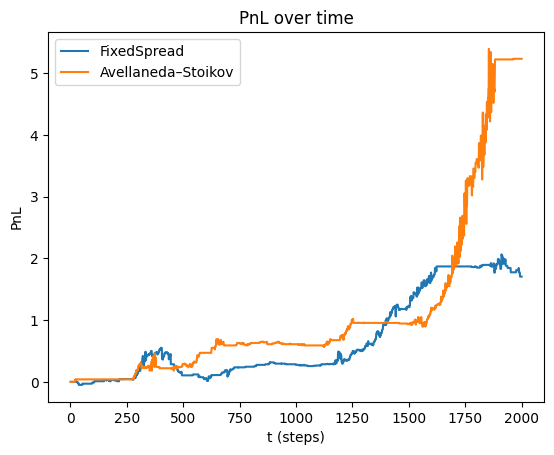

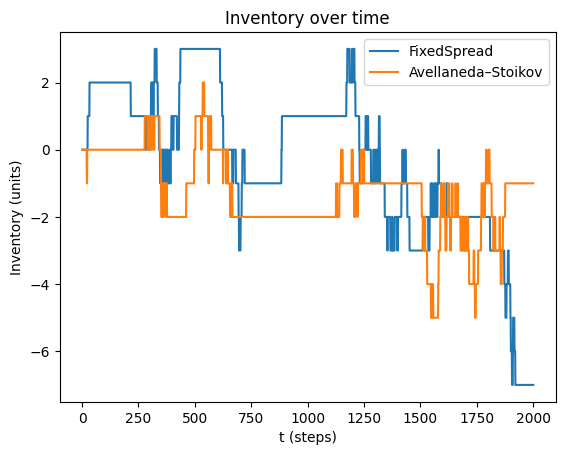

In [5]:
def plot_series(df1, df2, col, title, ylabel):
    plt.figure()
    plt.plot(df1["t"], df1[col], label="FixedSpread")
    plt.plot(df2["t"], df2[col], label="Avellaneda–Stoikov")
    plt.title(title)
    plt.xlabel("t (steps)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_series(fixed["df"], avs["df"], "pnl", "PnL over time", "PnL")
plot_series(fixed["df"], avs["df"], "inventory", "Inventory over time", "Inventory (units)")


## Optional: quick diagnostics

- Spread over time
- Fill events per step


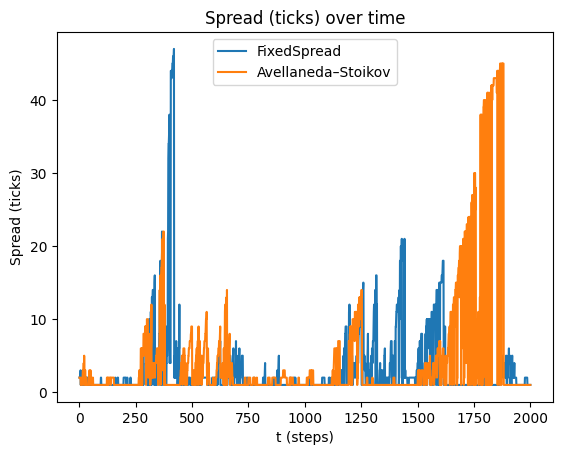

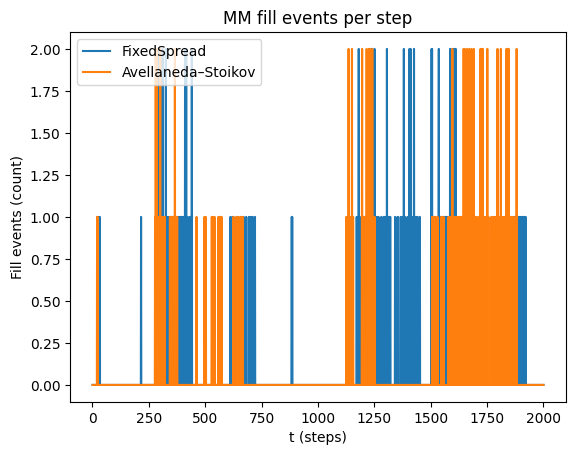

In [6]:
plot_series(fixed["df"], avs["df"], "spread_ticks", "Spread (ticks) over time", "Spread (ticks)")
plot_series(fixed["df"], avs["df"], "mm_fill_count", "MM fill events per step", "Fill events (count)")


## Robustness: multi-seed experiment

Single-seed results can be misleading.  
This cell runs both strategies across multiple random seeds and summarizes performance.

What it reports:
- Mean / std of total PnL
- Mean Sharpe (per-step)
- Worst max drawdown (most negative outcome)
- Mean inventory std (risk proxy)
- Mean adverse-selection hit rate


In [7]:
import numpy as np
import pandas as pd

# Choose seeds to test (increase to 50+ later if you want)
seeds = list(range(10, 30))  # 20 runs

def run_one(seed, mm_factory):
    cfg_seeded = SimConfig(
        steps=2000,
        seed=seed,
    )
    mm = mm_factory()
    sim = Simulator(config=cfg_seeded, mm=mm)
    res = sim.run()
    m = compute_metrics(res.history, mid_horizon=10)
    d = as_dict(m)
    return {
        "seed": seed,
        "total_pnl": d["total_pnl"],
        "sharpe_step": d["sharpe_step"],
        "max_drawdown": d["max_drawdown"],
        "inv_std": d["inv_std"],
        "adv_hit_rate": d["adv_hit_rate"],
        "avg_spread_ticks": d["avg_spread_ticks"],
        "fill_event_rate": d["fill_event_rate"],
    }

# Factories so each run gets a fresh strategy object (important because A–S keeps rolling state)
fixed_factory = lambda: FixedSpreadMarketMaker(half_spread_ticks=2, quote_size=1, max_inventory=25)

avs_factory = lambda: AvellanedaStoikovMarketMaker(
    gamma=0.05,
    base_half_spread_ticks=1,
    spread_mult=1.2,
    inv_spread_mult=0.05,
    sigma_window=50,
    quote_size=1,
    max_inventory=25,
)

fixed_rows = [run_one(s, fixed_factory) for s in seeds]
avs_rows = [run_one(s, avs_factory) for s in seeds]

fixed_df = pd.DataFrame(fixed_rows)
avs_df = pd.DataFrame(avs_rows)

def summarize(df, name):
    return pd.Series({
        "strategy": name,
        "n_seeds": len(df),
        "mean_pnl": df["total_pnl"].mean(),
        "std_pnl": df["total_pnl"].std(ddof=1),
        "mean_sharpe_step": df["sharpe_step"].mean(),
        "worst_max_drawdown": df["max_drawdown"].max(),  # higher drawdown is worse
        "mean_inv_std": df["inv_std"].mean(),
        "mean_adv_hit_rate": df["adv_hit_rate"].mean(),
        "mean_avg_spread_ticks": df["avg_spread_ticks"].mean(),
        "mean_fill_event_rate": df["fill_event_rate"].mean(),
    })

summary_multi = pd.DataFrame([
    summarize(fixed_df, "FixedSpread"),
    summarize(avs_df, "Avellaneda–Stoikov"),
]).set_index("strategy")

summary_multi


,n_seeds,mean_pnl,std_pnl,mean_sharpe_step,worst_max_drawdown,mean_inv_std,mean_adv_hit_rate,mean_avg_spread_ticks,mean_fill_event_rate
strategy,,,,,,,,,
FixedSpread,20,1.40625,6.608424,0.004619,20.310,6.267124,0.398280,4.417075,0.110425
Avellaneda–Stoikov,20,4.32975,2.540295,0.033257,2.685,2.002129,0.366923,4.648050,0.070950
